In [1]:
%reset


In [2]:
##GJ##
import time
import numpy as np
import math 
import pylab as pl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.constants import c
from scipy.constants import epsilon_0
import scipy.io as sio
import h5py
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
from numba import jit

from refractive_index import n_PPLN

In [3]:
## Time and frequency variables

dt = 4e-15
T = 2e-12
nt =2**math.ceil(np.log2(T/dt))
T = nt*dt
t = np.sort(-np.arange((-nt/2)*dt,(nt/2)*dt,dt))
w = np.arange(-nt/2,nt/2)*2*np.pi/dt/nt
dw = abs(w[0] - w[1])

lp = 1.03e-6  # pump central wavelength 
ls = 1.75e-6 # signal central wavelength
li = 1/(1/lp-1/ls) # idler central wavelength 
l2p = lp/2
l2s = ls/2
l2i = li/2

wp = 2*np.pi*c/lp
ws = 2*np.pi*c/ls
wi = 2*np.pi*c/li
w2p = 2*np.pi*c/l2p
w2s = 2*np.pi*c/l2s
w2i = 2*np.pi*c/l2i
l = (2*c*np.pi)/(w+wp)

lvp = c*2*np.pi/(wp+w)
lvs = c*2*np.pi/(ws+w)
lvi = c*2*np.pi/(wi+w)
lv2p = c*2*np.pi/(w2p+w)
lv2s = c*2*np.pi/(w2s+w)
lv2i = c*2*np.pi/(w2i+w)

## Dispersion & NL coeff

deff = 14e-12
#angleNC = 3
#tetas = (90+ angleNC)*np.pi/180
#tetap = 90*np.pi/180

Convention : i - s --> p


type I : e - e --> e


In [4]:
indexep = np.nan_to_num(n_PPLN(lvp,T =140),copy = False, nan = 1)
indexes = np.nan_to_num(n_PPLN(lvs,T =140),copy = False, nan = 1)
indexei = np.nan_to_num(n_PPLN(lvi,T =140),copy = False, nan = 1)
indexe2p = np.nan_to_num(n_PPLN(lv2p,T =140),copy = False, nan = 1)
indexe2s = np.nan_to_num(n_PPLN(lv2s,T =140),copy = False, nan = 1)
indexe2i = np.nan_to_num(n_PPLN(lv2i,T =140),copy = False, nan = 1)

betaep = (w+wp) * indexep / c
betaes = (w+ws) * indexes / c
betaei = (w+wi) * indexei / c
betae2p = (w+w2p) * indexe2p / c
betae2s = (w+w2s) * indexe2s / c
betae2i = (w+w2i) * indexe2i / c

beta1p = np.gradient(betaes,w)
beta1s = np.gradient(betaes,w)
beta1i = np.gradient(betaei,w)

vg0p = 1/beta1p[int(nt/2)]
vg0s = 1/beta1s[int(nt/2)]
vg0i = 1/beta1i[int(nt/2)]

#print(np.round(vg0p*100/c,2),np.round(vg0s*100/c,2),np.round(vg0i*100/c,2))

In [5]:
## Spatial variables (z propagation)

nz = 10_000
dz = 0.1e-6
Dz = 5e-6
Nz = round(nz * dz / Dz)
ratio = round(Dz / dz)
z = np.arange(0,(nz-1)*dz,dz)+dz
Z = np.arange(0,(nz-1)*dz,Dz)+Dz

## Radial variable (transverse beam size)

nr =45
dr = 25e-6
r = np.arange(0,nr*dr+dr,dr)

## Initial conditions
## Pump

energiep = 125e-6 
pump_duration = 150e-15
tgaussp = pump_duration / (np.sqrt(2 * np.log(2))) 
rgaussp = 600e-6 
ep = np.exp(-(t / tgaussp)**2) 

## Signal 

energies = 0.4e-6 
signal_duration = 100e-15
tgausss = signal_duration / (np.sqrt(2 * np.log(2))) 
es = np.exp(-(t / tgausss)**2) 
rgausss = 550e-6 
phi2s = 0
phi3s = 0

In [6]:
## Ratio and intensity  

energieintp = np.sum(abs(ep**2)) * dt * 2 * indexep[int(nt/2)] * c * epsilon_0 * (np.pi * rgaussp**2) / 2
energieints = np.sum(abs(es**2)) * dt * 2 * indexes[int(nt/2)] * c * epsilon_0 * (np.pi * rgausss**2) / 2

ecretep = np.max(abs(ep)) * np.sqrt(energiep / energieintp)
ecretes = np.max(abs(es)) * np.sqrt(energies / energieints)

icretes = 2 * indexes[int(nt/2)] * c * epsilon_0 * ecretes**2 
icretep = 2 * indexep[int(nt/2)] * c * epsilon_0 * ecretep**2 # magnitude of icretep

print(icretes*1e-14,icretep*1e-14)

0.07908288879595235 13.844082095356242


In [7]:
ep = ep / np.max(abs(ep)) 
es = es / np.max(abs(es)) * np.exp(1j*np.pi*0) 

tposp =  -200*1e-15
ep = np.roll(ep, int(np.round(tposp/dt)))

tposs = 0*1e-15
es = np.roll(es, int(np.round(tposs/dt)))

In [8]:
epinr = ecretep * np.exp(-(r / rgaussp)**2)
esinr = ecretes * np.exp(-(r / rgausss)**2)

Ptot = np.sum(epinr**2 * 2 * indexep[int(nt/2)] * c * epsilon_0 * 2 * np.pi * r) * dr # if sup a Pc -->  problem

OPA

In [9]:
@jit
def dispersion(epw,esw,eiw,e2pw,e2sw,e2iw):
    epw = epw * (np.exp(-1j * dz/2 * (betaep) + 1j * dz/2 * w / vg0s)).T
    esw = esw * (np.exp(-1j * dz/2 * (betaes) + 1j * dz/2 * w / vg0s)).T
    eiw = eiw * (np.exp(-1j * dz/2 * (betaei) + 1j * dz/2 * w / vg0s)).T
    e2pw = e2pw * (np.exp(-1j * dz/2 * (betae2p) + 1j * dz/2 * w / vg0s)).T
    e2sw = e2sw * (np.exp(-1j * dz/2 * (betae2s) + 1j * dz/2 * w / vg0s)).T
    e2iw = e2iw * (np.exp(-1j * dz/2 * (betae2i) + 1j * dz/2 * w / vg0s)).T

    return epw,esw,eiw,e2pw,e2sw,e2iw
@jit
def fast_ifft(epw,esw,eiw,e2pw,e2sw,e2iw):
    
    ept = np.fft.ifft(np.fft.ifftshift(epw,axes = 0),axis = 0)
    est = np.fft.ifft(np.fft.ifftshift(esw,axes = 0),axis = 0)
    eit = np.fft.ifft(np.fft.ifftshift(eiw,axes = 0),axis = 0)
    e2pt = np.fft.ifft(np.fft.ifftshift(e2pw,axes = 0),axis = 0)
    e2st = np.fft.ifft(np.fft.ifftshift(e2sw,axes = 0),axis = 0)
    e2it = np.fft.ifft(np.fft.ifftshift(e2iw,axes = 0),axis = 0)

    return ept,est,eit,e2pt,e2st,e2it

@jit
def toutesp(ept):

    epw = np.fft.fftshift(np.fft.fft(ept,axis = 0),axes = 0) 
    epw = epw * (np.exp(-1j * dz/2 * (betaep) + 1j * dz/2 * w / vg0s)).T
    epw = epw * (np.exp(-(w / (dw*nt*0.5))**100)).T
    ept = np.fft.ifft(np.fft.ifftshift(epw,axes = 0),axis = 0)
    ept = ept * (np.exp(-(t / (dt * nt * 0.45))**40)).T
    epw = np.fft.fftshift(np.fft.fft(ept,axis = 0),axes = 0) 

    return epw
@jit
def toutess(ept):

    epw = np.fft.fftshift(np.fft.fft(ept,axis = 0),axes = 0) 
    epw = epw * (np.exp(-1j * dz/2 * (betaes) + 1j * dz/2 * w / vg0s)).T
    epw = epw * (np.exp(-(w / (dw*nt*0.5))**100)).T
    ept = np.fft.ifft(np.fft.ifftshift(epw,axes = 0),axis = 0)
    ept = ept * (np.exp(-(t / (dt * nt * 0.45))**40)).T
    epw = np.fft.fftshift(np.fft.fft(ept,axis = 0),axes = 0) 

    return epw
@jit
def toutesi(ept):

    epw = np.fft.fftshift(np.fft.fft(ept,axis = 0),axes = 0) 
    epw = epw * (np.exp(-1j * dz/2 * (betaei) + 1j * dz/2 * w / vg0s)).T
    epw = epw * (np.exp(-(w / (dw*nt*0.5))**100)).T
    ept = np.fft.ifft(np.fft.ifftshift(epw,axes = 0),axis = 0)
    ept = ept * (np.exp(-(t / (dt * nt * 0.45))**40)).T
    epw = np.fft.fftshift(np.fft.fft(ept,axis = 0),axes = 0) 

    return epw
@jit
def toutes2p(ept):

    epw = np.fft.fftshift(np.fft.fft(ept,axis = 0),axes = 0) 
    epw = epw * (np.exp(-1j * dz/2 * (betae2p) + 1j * dz/2 * w / vg0s)).T
    epw = epw * (np.exp(-(w / (dw*nt*0.5))**100)).T
    ept = np.fft.ifft(np.fft.ifftshift(epw,axes = 0),axis = 0)
    ept = ept * (np.exp(-(t / (dt * nt * 0.45))**40)).T
    epw = np.fft.fftshift(np.fft.fft(ept,axis = 0),axes = 0) 

    return epw
@jit
def toutes2s(ept):

    epw = np.fft.fftshift(np.fft.fft(ept,axis = 0),axes = 0) 
    epw = epw * (np.exp(-1j * dz/2 * (betae2s) + 1j * dz/2 * w / vg0s)).T
    epw = epw * (np.exp(-(w / (dw*nt*0.5))**100)).T
    ept = np.fft.ifft(np.fft.ifftshift(epw,axes = 0),axis = 0)
    ept = ept * (np.exp(-(t / (dt * nt * 0.45))**40)).T
    epw = np.fft.fftshift(np.fft.fft(ept,axis = 0),axes = 0) 

    return epw
@jit
def toutes2i(ept):

    epw = np.fft.fftshift(np.fft.fft(ept,axis = 0),axes = 0) 
    epw = epw * (np.exp(-1j * dz/2 * (betae2i) + 1j * dz/2 * w / vg0s)).T
    epw = epw * (np.exp(-(w / (dw*nt*0.5))**100)).T
    ept = np.fft.ifft(np.fft.ifftshift(epw,axes = 0),axis = 0)
    ept = ept * (np.exp(-(t / (dt * nt * 0.45))**40)).T
    epw = np.fft.fftshift(np.fft.fft(ept,axis = 0),axes = 0) 

    return epw

In [10]:
ept = np.zeros((3,nt,len(r)),dtype=complex)
epw = np.zeros((3,nt,len(r)),dtype=complex)
ept[0] = np.expand_dims(epinr, axis=0) * np.expand_dims(ep, axis=0).T
epw[0] = np.fft.fftshift(np.fft.fft(ept[0],axis = 0),axes = 0) 

est = np.zeros((3,nt,len(r)),dtype=complex)
esw = np.zeros((3,nt,len(r)),dtype=complex)
est[0] = np.expand_dims(esinr, axis=0) * np.expand_dims(es, axis=0).T
esw[0] = np.fft.fftshift(np.fft.fft(est[0],axis = 0),axes = 0) 


energiein = (abs(ept[0])**2 + abs(est[0])**2).sum(axis = 0)

eit = np.zeros((3,nt,len(r)),dtype=complex)
eiw = np.zeros((3,nt,len(r)),dtype=complex)
e2pt = np.zeros((3,nt,len(r)),dtype=complex)
e2pw = np.zeros((3,nt,len(r)),dtype=complex)
e2st = np.zeros((3,nt,len(r)),dtype=complex)
e2sw = np.zeros((3,nt,len(r)),dtype=complex)
e2it = np.zeros((3,nt,len(r)),dtype=complex)
e2iw = np.zeros((3,nt,len(r)),dtype=complex)


betaep = np.expand_dims(betaep, axis=0)
betaes = np.expand_dims(betaes, axis=0)
betaei = np.expand_dims(betaei, axis=0)
betae2p = np.expand_dims(betae2p, axis=0)
betae2s = np.expand_dims(betae2s, axis=0)
betae2i = np.expand_dims(betae2i, axis=0)


w = np.expand_dims(w, axis=0)
t = np.expand_dims(t, axis=0)

phi2s = 0 *1e-30
esw[0] = esw[0] * (np.exp(-1j * (w**2 * phi2s / 2+ w**3 * phi3s / 6))).T

epw[1] = epw[0]
esw[1] = esw[0]

period = 30*1e-6
domain = int(period/dz/2)
pivot = 1



phi2s = 20000 *1e-30
esw[0] = esw[0] * (np.exp(-1j * (w**2 * phi2s / 2+ w**3 * phi3s / 6))).T
est[0] = np.fft.ifft(np.fft.ifftshift(esw[0],axes = 0),axis = 0)
esw[0] = np.fft.fftshift(np.fft.fft(est[0],axis = 0),axes = 0)
plt.plot(t.T*1e15,abs(est[0].T[0]**2))
plt.xlim(-500,500)
plt.show()

In [12]:
tic = time.time()

for k in range(nz):

    if (k/domain)==round(k/domain):
        pivot = - pivot

    epw[1],esw[1],eiw[1],e2pw[1],e2sw[1],e2iw[1] = dispersion(epw[1],esw[1],eiw[1],e2pw[1],e2sw[1],e2iw[1])
    
    ept[1],est[1],eit[1],e2pt[1],e2st[1],e2it[1] = fast_ifft(epw[1],esw[1],eiw[1],e2pw[1],e2sw[1],e2iw[1])

    ept[2] = ept[1] + 2 * wp * pivot * deff / indexep[int(nt/2)] / c * 1j * dz  * (est[1] * eit[1] - np.conj(ept[1]) * e2pt[1])
    est[2] = est[1] + 2 * ws * pivot * deff / indexes[int(nt/2)] / c * 1j * dz  * (ept[1] * np.conj(eit[1]) - np.conj(est[1]) * e2st[1])
    eit[2] = eit[1] + 2 * wi * pivot * deff / indexei[int(nt/2)] / c * 1j * dz  * (ept[1] * np.conj(est[1]) - np.conj(eit[1]) * e2it[1])
    e2pt[2] = e2pt[1] - w2p * pivot * deff / indexe2p[int(nt/2)] / c * 1j * dz  * (ept[1]**2)
    e2st[2] = e2st[1] - w2s * pivot * deff / indexe2s[int(nt/2)] / c * 1j * dz  * (est[1]**2)
    e2it[2] = e2it[1] - w2i * pivot * deff / indexe2i[int(nt/2)] / c * 1j * dz  * (eit[1]**2)
    
    epw[2] = toutesp(ept[2])
    esw[2] = toutess(est[2])
    eiw[2] = toutesi(eit[2])
    e2pw[2] = toutes2p(e2pt[2])
    e2sw[2] = toutes2s(e2st[2])
    e2iw[2] = toutes2i(e2it[2])
    
    epw[1] = epw[2]
    esw[1] = esw[2]
    eiw[1] = eiw[2]
    e2pw[1] = e2pw[2]
    e2sw[1] = e2sw[2]
    e2iw[1] = e2iw[2]
        
toc = time.time()
print(f"{(toc-tic)} s")

107.48598194122314 s


In [13]:
lvp[lvp <= 0] = 1
lvs[lvs <= 0] = 1
lvi[lvi <= 0] = 1

In [14]:
PumpSpatial = np.sum ((abs(ept[-1]**2)*np.exp(1j*np.angle(ept[-1]))), axis = 0 ) # propor fluence J/m2 (fluence +  phase)
SignalSpatial = np.sum ((abs(est[-1]**2)*np.exp(1j*np.angle(est[-1]))), axis = 0 )
IdlerSpatial = np.sum ((abs(eit[-1]**2)*np.exp(1j*np.angle(eit[-1]))), axis = 0 )
Pump2Spatial = np.sum ((abs(e2pt[-1]**2)*np.exp(1j*np.angle(e2pt[-1]))), axis = 0 )
Signal2Spatial = np.sum ((abs(e2st[-1]**2)*np.exp(1j*np.angle(e2st[-1]))), axis = 0 )
Idler2Spatial = np.sum ((abs(e2it[-1]**2)*np.exp(1j*np.angle(e2it[-1]))), axis = 0 )


In [15]:
energiepout = np.sum(abs(PumpSpatial * r)) * 2 * np.pi * dr * dt * 2 * epsilon_0 * indexep[int(nt/2)] * c
energiesout = np.sum(abs(SignalSpatial * r)) * 2 * np.pi * dr * dt * 2 * epsilon_0 * indexes[int(nt/2)] * c
energieiout = np.sum(abs(IdlerSpatial * r)) * 2 * np.pi * dr * dt * 2 * epsilon_0 * indexei[int(nt/2)] * c
energie2pout = np.sum(abs(Pump2Spatial * r)) * 2 * np.pi * dr * dt * 2 * epsilon_0 * indexe2p[int(nt/2)] * c
energie2sout = np.sum(abs(Signal2Spatial * r)) * 2 * np.pi * dr * dt * 2 * epsilon_0 * indexe2s[int(nt/2)] * c
energie2iout = np.sum(abs(Idler2Spatial * r)) * 2 * np.pi * dr * dt * 2 * epsilon_0 * indexe2i[int(nt/2)] * c
EnerTot1 = energiepout + energiesout + energieiout
EnerTot2 = energie2pout + energie2sout + energie2iout
print(f"Express in micro J\nEnergie pump in {np.round( energiep * 1e6,6)}\nEnergie signal in {np.round( energies * 1e6,6)}\nEnergie total {np.round((EnerTot1 + EnerTot2) * 1e6,6)}\nEnergie pump out {np.round( energiepout * 1e6,6)}\nEnergie signal out {np.round(energiesout * 1e6,6)}\nEnergie idler out {np.round(energieiout * 1e6,6)}\nEnergie 2pump out {np.round(energie2pout * 1e6,6)}\nEnergie 2signal out {np.round(energie2sout * 1e6,10)}\nEnergie 2idler out {np.round(energie2iout * 1e6,10)}")

Express in micro J
Energie pump in 125.0
Energie signal in 0.4
Energie total 107.665147
Energie pump out 72.747081
Energie signal out 18.744741
Energie idler out 13.060302
Energie 2pump out 2.832157
Energie 2signal out 0.1590726505
Energie 2idler out 0.1217931712


In [16]:
Globaleffsignal = np.sum(abs(SignalSpatial * r))/(np.sum(abs(epinr**2)*r)*np.sum(abs(ep)**2))
Globaleffidler = np.sum(abs(IdlerSpatial * r))/(np.sum(abs(epinr**2)*r)*np.sum(abs(ep)**2))
Globaleffpump = np.sum(abs(PumpSpatial* r))/ (np.sum(abs(epinr**2)*r)*np.sum(abs(ep)**2))
Globalgainsignal = np.sum(abs(SignalSpatial*r))/(np.sum(abs(esinr**2)*r)*np.sum(abs(es)**2))
print (f' pump efficacite {round(Globaleffpump,2)}, signal efficacite {round(Globaleffsignal,2)}, idler efficacite {round(Globaleffidler,2)}, global signal gain {Globalgainsignal}')

 pump efficacite 0.58, signal efficacite 0.15, idler efficacite 0.11, global signal gain 46.90030784217315


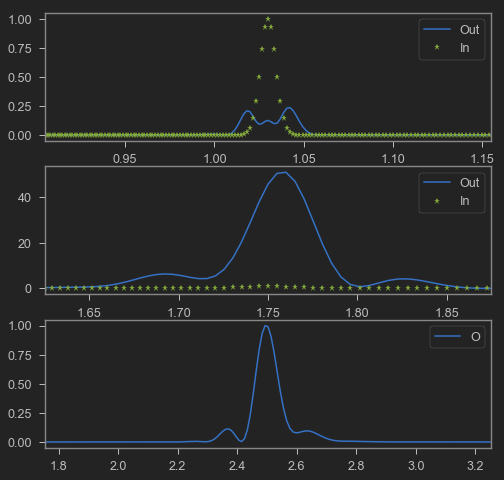

In [17]:
plt.figure(figsize = (8,8))
plt.subplot(311)
plt.plot(lvp*1e6,abs(epw[-1].T[0]**2)/max(abs(epw[0].T[0]**2)),lvp*1e6,abs(epw[0].T[0]**2)/max(abs(epw[0].T[0]**2)),'*')
plt.xlim(lp*1e6-0.125,lp*1e6+0.125)
plt.gca().legend(('Out','In'))
plt.subplot(312)
plt.plot(lvs*1e6,abs(esw[-1].T[0]**2)/max(abs(esw[0].T[0]**2)),lvs*1e6,abs(esw[0].T[0]**2)/max(abs(esw[0].T[0]**2)),'*')
plt.xlim(ls*1e6-0.125,ls*1e6+0.125)
plt.gca().legend(('Out','In'))
plt.subplot(313)
plt.plot(lvi*1e6,abs(eiw[-1].T[0]**2)/max(abs(eiw[-1].T[0]**2)))
plt.xlim(li*1e6-0.75,li*1e6+0.75)
plt.gca().legend(('Out'))
plt.show()

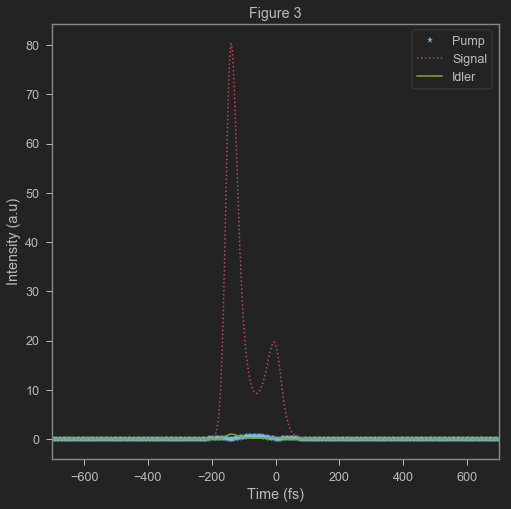

In [18]:
plt.figure(figsize=(8,8))
(plt.plot(t.T*1e15,abs(ept[2].T[0]**2)/max(abs(ept[0].T[0]**2)),'c*',
          t.T*1e15,abs(est[2].T[0]**2)/max(abs(est[0].T[0]**2)),'r:',
          t.T*1e15,abs(eit[2].T[0]**2)/max(abs(eit[1].T[0]**2)),'g'))
plt.xlim(-700,700)
#plt.ylim(0,5)
plt.xlabel('Time (fs)')
plt.ylabel('Intensity (a.u)')
plt.title('Figure 3')
plt.gca().legend(('Pump','Signal','Idler'))
plt.title('Figure 3')
plt.show()

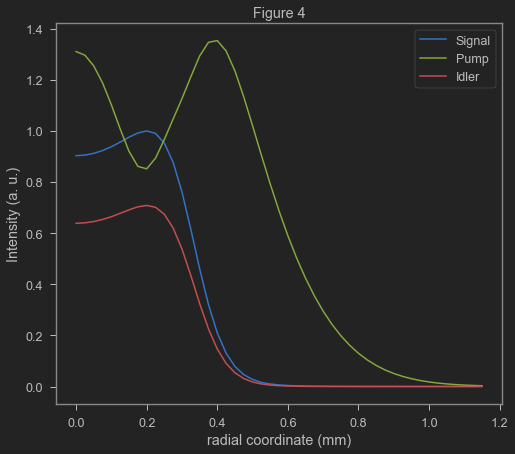

In [19]:
(plt.plot(r*1e3,abs(SignalSpatial)/max(abs(SignalSpatial)),
          r*1e3,abs(PumpSpatial)/max(abs(SignalSpatial)),
          r*1e3,abs(IdlerSpatial)/max(abs(SignalSpatial))))
plt.xlabel('radial coordinate (mm)')
plt.ylabel('Intensity (a. u.)')
plt.title('Figure 4')
plt.gca().legend(('Signal','Pump','Idler'))
plt.show()

In [20]:
Energie_total =np.mean((np.sum(abs(ept[-1]**2), axis = 0)+ np.sum(abs(est[-1]**2), axis = 0) + np.sum(abs(eit[-1]**2), axis = 0)+np.sum(abs(e2pt[-1]**2), axis = 0)+ np.sum(abs(e2st[-1]**2), axis = 0) + np.sum(abs(e2it[-1]**2), axis = 0)) / (np.sum(abs(ept[0]**2), axis = 0)+np.sum(abs(est[0]**2), axis = 0)+np.sum(abs(eit[0]**2), axis = 0)+np.sum(abs(e2pt[0]**2), axis = 0)+np.sum(abs(e2st[0]**2), axis = 0)+np.sum(abs(e2it[0]**2), axis = 0)))
Energie_total

1.0005864520609502

In [21]:
with h5py.File('PPLN_OPA3_data.h5','w') as hf:
    hf.create_dataset('Pump_electric_field_in', data = ept[0])
    hf.create_dataset('Pump_electric_field_out', data = ept[-1])
    hf.create_dataset('Signal_electric_field_in', data = est[0])
    hf.create_dataset('Signal_electric_field_out', data = est[-1])
    hf.create_dataset('Idler_electric_field_out', data = eit[-1])
    hf.create_dataset('Time', data = t)
    hf.create_dataset('wavelength_pump', data = lvp)
    hf.create_dataset('wavelength_signal', data = lvs)
    hf.create_dataset('wavelength_idler', data = lvi)
    hf.create_dataset('Pump_spectrum_in', data = epw[0])
    hf.create_dataset('Signal_spectrum_in', data = esw[0])
    hf.create_dataset('Idler_spectrum_out', data = eiw[-1])
    hf.create_dataset('Pump_spectrum_out', data = epw[-1])
    hf.create_dataset('Signal_spectrum_out', data = esw[-1])
    hf.create_dataset('Energie_pump_in', data = energiep)
    hf.create_dataset('Energie_signal_in', data = energies)
    hf.create_dataset('Energie_pump_out', data = energiepout)
    hf.create_dataset('Energie_signal_out', data = energiesout)
    hf.create_dataset('Energie_idler_out', data = energieiout)
    hf.create_dataset('Rayon_pump', data = rgaussp)
    hf.create_dataset('Rayon_signal', data = rgausss)
    hf.create_dataset('I_pump_in', data = icretep)
    hf.create_dataset('I_signal_in', data = icretes)
    hf.create_dataset('Cut_angle', data = period)
    hf.create_dataset('CrystalLength', data = nz*dz)
    hf.create_dataset('CentralWPump', data = lp*1e9)
    hf.create_dataset('CentralWSignal', data = ls*1e9)
    hf.create_dataset('CentralWIdler', data = li*1e9)

